Using device: cuda
Getting NARMA data...
seed: 2027
Train samples: 160, Val samples: 34, Test samples: 35

Starting training...
Epoch 1/50 [0.01s] - Train Loss: 0.108977, Val Loss: 0.104010
Epoch 2/50 [0.01s] - Train Loss: 0.103477, Val Loss: 0.112492
Epoch 3/50 [0.01s] - Train Loss: 0.096563, Val Loss: 0.090937
Epoch 4/50 [0.01s] - Train Loss: 0.085687, Val Loss: 0.101121
Epoch 5/50 [0.02s] - Train Loss: 0.086903, Val Loss: 0.090282
Epoch 6/50 [0.02s] - Train Loss: 0.082275, Val Loss: 0.088985
Epoch 7/50 [0.01s] - Train Loss: 0.079904, Val Loss: 0.095481
Epoch 8/50 [0.01s] - Train Loss: 0.078851, Val Loss: 0.095664
Epoch 9/50 [0.01s] - Train Loss: 0.078720, Val Loss: 0.089622
Epoch 10/50 [0.01s] - Train Loss: 0.077468, Val Loss: 0.097648
Epoch 11/50 [0.01s] - Train Loss: 0.076536, Val Loss: 0.098277
Epoch 12/50 [0.01s] - Train Loss: 0.071930, Val Loss: 0.093021
Epoch 13/50 [0.01s] - Train Loss: 0.073458, Val Loss: 0.099090
Epoch 14/50 [0.01s] - Train Loss: 0.072781, Val Loss: 0.102890

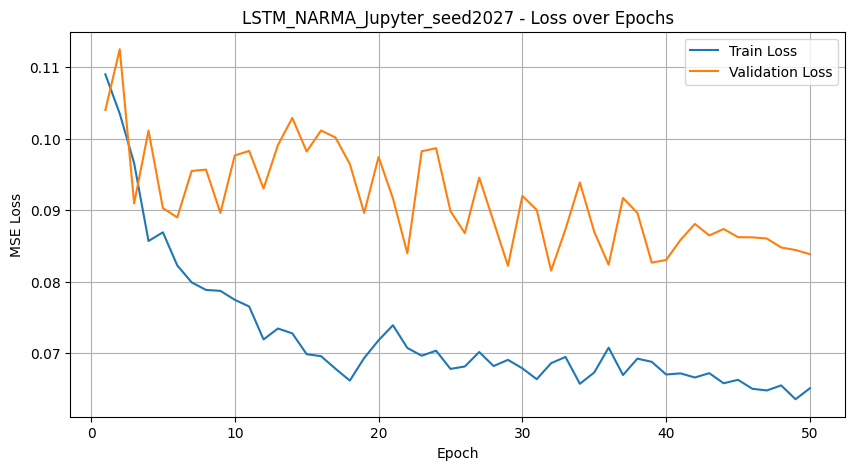


Generating final predictions on the full dataset...
Prediction plot saved to LSTM_NARMA_Jupyter_seed2027/prediction_vs_truth.png


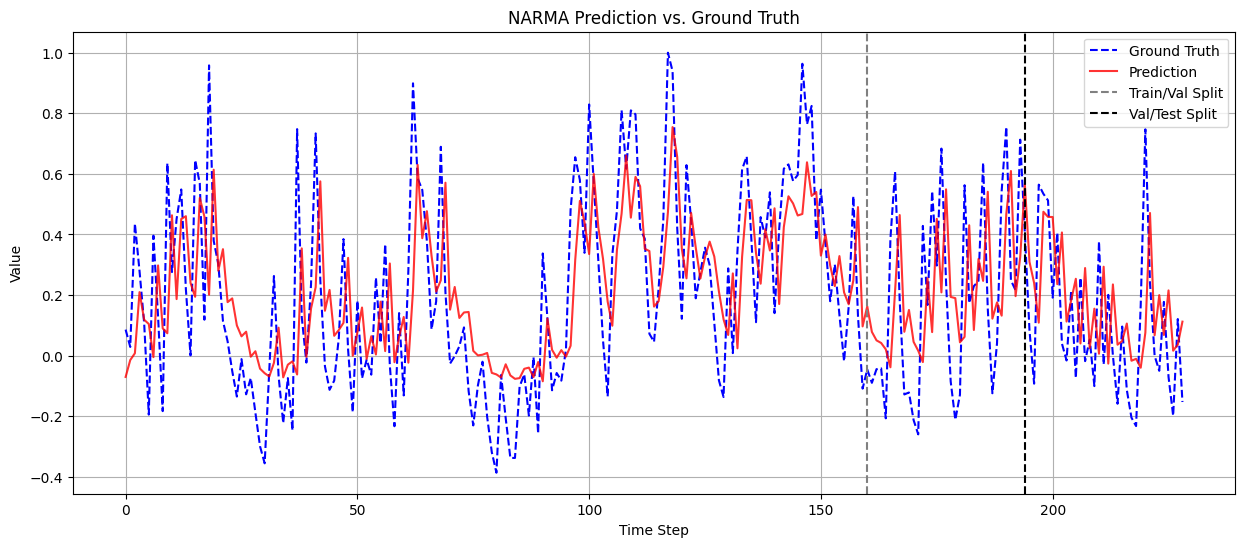

Predictions saved to LSTM_NARMA_Jupyter_seed2027/prediction_vs_truth.csv


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import os
import time
from datetime import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt

# Make sure narma.py is in the same directory or accessible
from narma import get_narma_data

# ===================================================================
# 1. Hyperparameters and Configuration
# ===================================================================
SEED = 2027
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.01
HIDDEN_SIZE = 10
NUM_LAYERS = 2
exp_name = f"LSTM_NARMA_Jupyter_seed{SEED}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================================================================
# 2. Model Definition
# ===================================================================
class LSTMModel(nn.Module):
    """A standard LSTM model for sequence prediction."""
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# ===================================================================
# 3. Helper Functions
# ===================================================================
def train_epoch(model, optimizer, loader, loss_fn, device):
    """Training loop for one epoch."""
    model.train()
    total_loss = 0
    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = loss_fn(output.squeeze(), Y_batch.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def test_epoch(model, loader, loss_fn, device):
    """Evaluation loop."""
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            output = model(X_batch)
            loss = loss_fn(output.squeeze(), Y_batch.squeeze())
            total_loss += loss.item()
    return total_loss / len(loader)

def save_and_plot_metrics(exp_name, metrics_data):
    """Saves metrics to CSV and plots the results."""
    if not os.path.exists(exp_name):
        os.makedirs(exp_name)
    df_metrics = DataFrame(metrics_data)
    csv_path = os.path.join(exp_name, "final_training_metrics.csv")
    df_metrics.to_csv(csv_path, index=False)
    print(f"Final metrics saved to {csv_path}")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(df_metrics['epoch'], df_metrics['train_loss'], label='Train Loss')
    plt.plot(df_metrics['epoch'], df_metrics['val_loss'], label='Validation Loss')
    plt.title(f'{exp_name} - Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plot_path = os.path.join(exp_name, "loss_plot.png")
    plt.savefig(plot_path)
    print(f"Plot saved to {plot_path}")
    plt.show()

# ===================================================================
# 4. NEW: Prediction Plotting and Saving Function
# ===================================================================
def generate_and_save_predictions(model, full_data_x, full_data_y, train_end_idx, val_end_idx, exp_name):
    """Generates predictions, plots them against truth, and saves both."""
    print("\nGenerating final predictions on the full dataset...")
    model.eval()
    with torch.no_grad():
        # Ensure data is on the correct device
        full_data_x = full_data_x.to(device)
        predictions = model(full_data_x).cpu().numpy().squeeze()
    
    ground_truth = full_data_y.cpu().numpy().squeeze()
    
    # --- Plotting ---
    plt.figure(figsize=(15, 6))
    plt.plot(ground_truth, label='Ground Truth', color='blue', linestyle='--')
    plt.plot(predictions, label='Prediction', color='red', alpha=0.8)
    
    # Add vertical lines for data splits
    plt.axvline(x=train_end_idx, color='gray', linestyle='--', label='Train/Val Split')
    plt.axvline(x=val_end_idx, color='black', linestyle='--', label='Val/Test Split')
    
    plt.title('NARMA Prediction vs. Ground Truth')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    
    # Save the plot
    plot_path = os.path.join(exp_name, "prediction_vs_truth.png")
    plt.savefig(plot_path)
    print(f"Prediction plot saved to {plot_path}")
    plt.show()
    
    # --- Saving to CSV ---
    df_preds = DataFrame({
        'ground_truth': ground_truth,
        'prediction': predictions
    })
    csv_path = os.path.join(exp_name, "prediction_vs_truth.csv")
    df_preds.to_csv(csv_path, index=False)
    print(f"Predictions saved to {csv_path}")


# ===================================================================
# 5. Main Execution Block
# ===================================================================
# --- Setup ---
torch.manual_seed(SEED)
np.random.seed(SEED)
print(f"Using device: {device}")

# --- Data Loading ---
print("Getting NARMA data...")
x, y = get_narma_data(n_samples=240, seq_length=10, seed=SEED)
if x.dim() == 2:
    x = x.unsqueeze(-1)

train_end_idx = int(0.70 * len(x))
val_end_idx = int(0.85 * len(x))
x_train, y_train = x[:train_end_idx], y[:train_end_idx]
x_val, y_val = x[train_end_idx:val_end_idx], y[train_end_idx:val_end_idx]
x_test, y_test = x[val_end_idx:], y[val_end_idx:]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val, y_val), batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=BATCH_SIZE)
print(f"Train samples: {len(x_train)}, Val samples: {len(x_val)}, Test samples: {len(x_test)}")

# --- Model Initialization ---
model = LSTMModel(input_size=1, hidden_size=HIDDEN_SIZE, output_size=1, num_layers=NUM_LAYERS).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- Training Loop ---
metrics = {'epoch': [], 'train_loss': [], 'val_loss': [], 'test_loss': []}
print("\nStarting training...")
for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss = train_epoch(model, optimizer, train_loader, loss_fn, device)
    val_loss = test_epoch(model, val_loader, loss_fn, device)
    test_loss = test_epoch(model, test_loader, loss_fn, device) if epoch == EPOCHS - 1 else np.nan
    
    metrics['epoch'].append(epoch + 1)
    metrics['train_loss'].append(train_loss)
    metrics['val_loss'].append(val_loss)
    metrics['test_loss'].append(test_loss)
    
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{EPOCHS} [{epoch_time:.2f}s] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

print("\n--- Training Complete ---")
final_test_loss = metrics['test_loss'][-1]
print(f"Final Test Loss: {final_test_loss:.6f}")

save_and_plot_metrics(exp_name, metrics)
generate_and_save_predictions(model, x, y, train_end_idx, val_end_idx, exp_name)

### Hyperparameter tuning

STAGE 1: Starting Grid Search using Seed: 2025
Using device: cuda
Getting NARMA data for tuning...
seed: 2025

[1/12] Testing params: {'hidden_size': 10, 'num_layers': 1, 'learning_rate': 0.01}
Number of trainable parameters: 531
Validation Loss for params {'hidden_size': 10, 'num_layers': 1, 'learning_rate': 0.01}: 0.042845

[2/12] Testing params: {'hidden_size': 10, 'num_layers': 1, 'learning_rate': 0.005}
Number of trainable parameters: 531
Validation Loss for params {'hidden_size': 10, 'num_layers': 1, 'learning_rate': 0.005}: 0.043023

[3/12] Testing params: {'hidden_size': 10, 'num_layers': 2, 'learning_rate': 0.01}
Number of trainable parameters: 1,411
Validation Loss for params {'hidden_size': 10, 'num_layers': 2, 'learning_rate': 0.01}: 0.047860

[4/12] Testing params: {'hidden_size': 10, 'num_layers': 2, 'learning_rate': 0.005}
Number of trainable parameters: 1,411
Validation Loss for params {'hidden_size': 10, 'num_layers': 2, 'learning_rate': 0.005}: 0.044081

[5/12] Testin

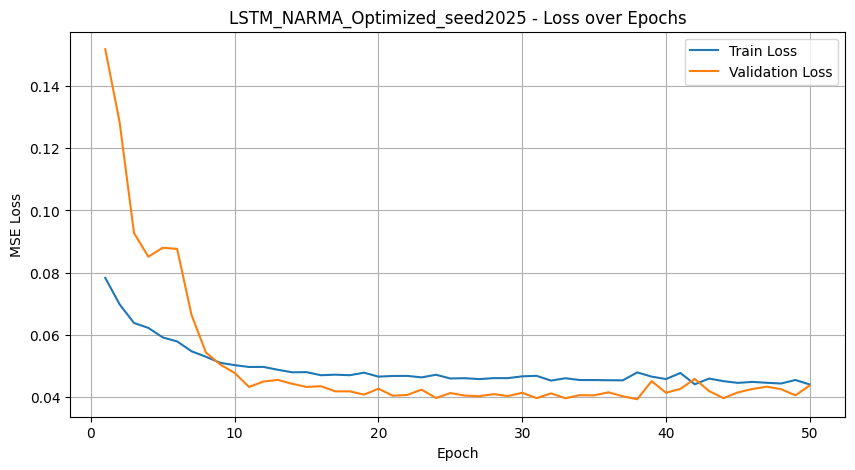


Generating final predictions on the full dataset...
Prediction plot saved to LSTM_NARMA_Optimized_seed2025/prediction_vs_truth.png


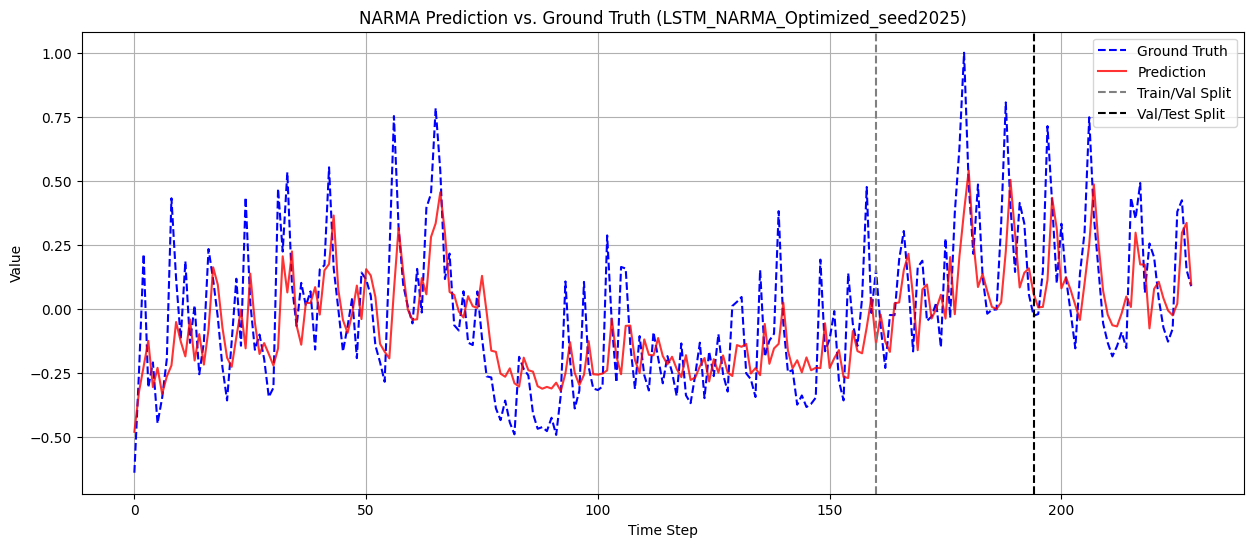

Predictions saved to LSTM_NARMA_Optimized_seed2025/prediction_vs_truth.csv

--- Running Final Experiment for Seed: 2026 ---
Getting NARMA data for seed 2026...
seed: 2026
Number of trainable parameters: 531
Epoch 10/50 - Train Loss: 0.065947, Val Loss: 0.057488
Epoch 20/50 - Train Loss: 0.058214, Val Loss: 0.057508
Epoch 30/50 - Train Loss: 0.054823, Val Loss: 0.060132
Epoch 40/50 - Train Loss: 0.054050, Val Loss: 0.054544
Epoch 50/50 - Train Loss: 0.053450, Val Loss: 0.070910

--- Final Training Complete for Seed {seed} ---
Final Test Loss for Seed 2026: 0.031839
Final metrics saved to LSTM_NARMA_Optimized_seed2026/final_training_metrics.csv
Plot saved to LSTM_NARMA_Optimized_seed2026/loss_plot.png


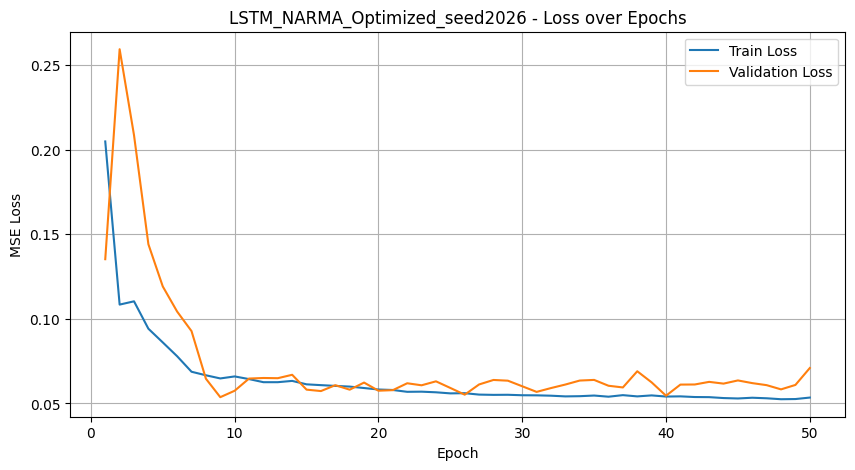


Generating final predictions on the full dataset...
Prediction plot saved to LSTM_NARMA_Optimized_seed2026/prediction_vs_truth.png


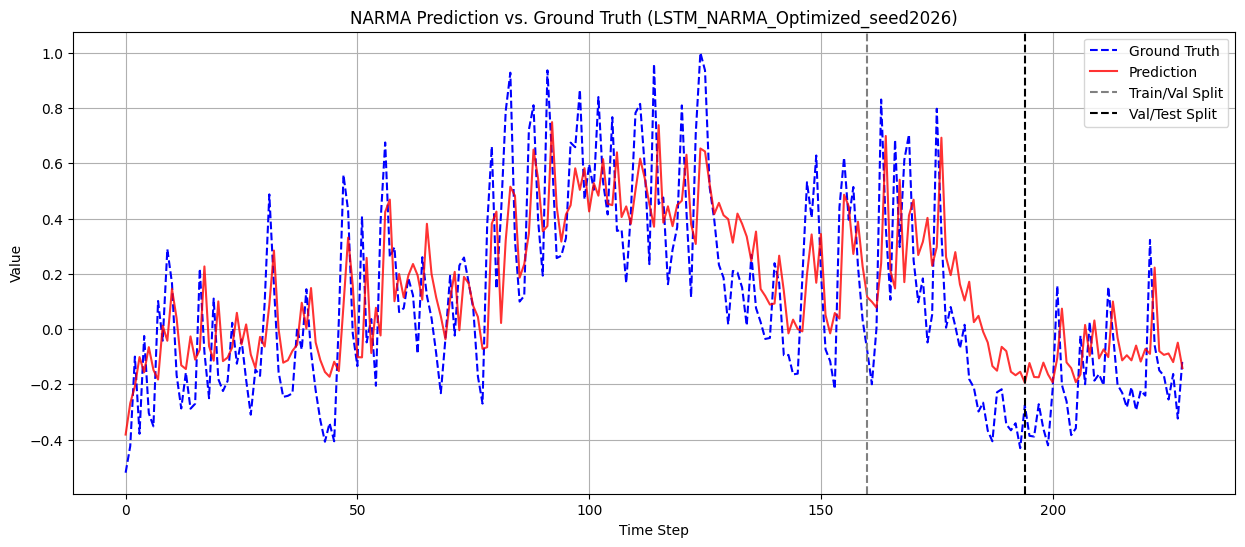

Predictions saved to LSTM_NARMA_Optimized_seed2026/prediction_vs_truth.csv

--- Running Final Experiment for Seed: 2027 ---
Getting NARMA data for seed 2027...
seed: 2027
Number of trainable parameters: 531
Epoch 10/50 - Train Loss: 0.072000, Val Loss: 0.094883
Epoch 20/50 - Train Loss: 0.068397, Val Loss: 0.098491
Epoch 30/50 - Train Loss: 0.068420, Val Loss: 0.099616
Epoch 40/50 - Train Loss: 0.066986, Val Loss: 0.090116
Epoch 50/50 - Train Loss: 0.066042, Val Loss: 0.086958

--- Final Training Complete for Seed {seed} ---
Final Test Loss for Seed 2027: 0.051500
Final metrics saved to LSTM_NARMA_Optimized_seed2027/final_training_metrics.csv
Plot saved to LSTM_NARMA_Optimized_seed2027/loss_plot.png


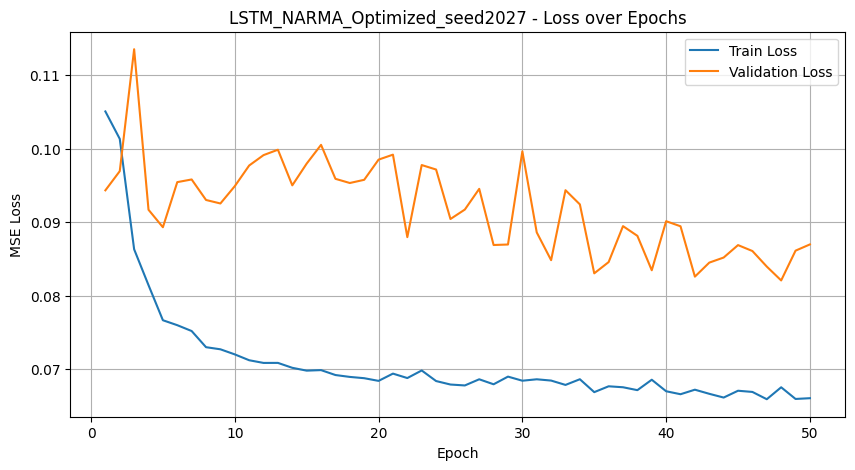


Generating final predictions on the full dataset...
Prediction plot saved to LSTM_NARMA_Optimized_seed2027/prediction_vs_truth.png


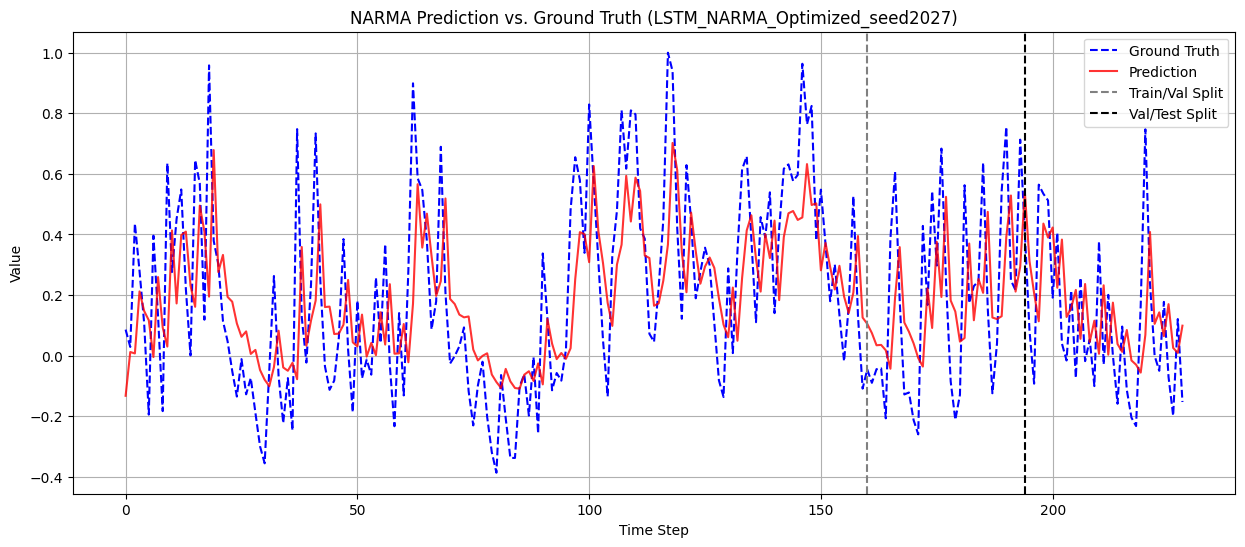

Predictions saved to LSTM_NARMA_Optimized_seed2027/prediction_vs_truth.csv

Grid search results saved to LSTM_NARMA_Optimized_seed2025/grid_search_results.csv


In [4]:
import torch
import torch.nn as nn
import numpy as np
import os
import time
from datetime import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
import itertools

# Make sure narma.py is in the same directory or accessible
from narma import get_narma_data

def count_parameters(model):
    """Counts the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ===================================================================
# 1. Configuration and Hyperparameter Grid
# ===================================================================
# --- Seed Configuration ---
TUNING_SEED = 2025
EVALUATION_SEEDS = [2025, 2026, 2027]

# --- Training Configuration ---
GRID_SEARCH_EPOCHS = 50  # Epochs for each grid search run
FINAL_EPOCHS = 50 # Epochs for the final model after finding best params
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Grid Search Hyperparameters ---
param_grid = {
    'hidden_size': [10, 20, 30],
    'num_layers': [1, 2],
    'learning_rate': [0.01, 0.005]
}

# ===================================================================
# 2. Model Definition
# ===================================================================
class LSTMModel(nn.Module):
    """A standard LSTM model for sequence prediction."""
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# ===================================================================
# 3. Helper Functions
# ===================================================================
def train_epoch(model, optimizer, loader, loss_fn, device):
    model.train()
    total_loss = 0
    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = loss_fn(output.squeeze(), Y_batch.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def test_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            output = model(X_batch)
            loss = loss_fn(output.squeeze(), Y_batch.squeeze())
            total_loss += loss.item()
    return total_loss / len(loader)

def save_and_plot_metrics(exp_name, metrics_data):
    if not os.path.exists(exp_name):
        os.makedirs(exp_name)
    df_metrics = DataFrame(metrics_data)
    csv_path = os.path.join(exp_name, "final_training_metrics.csv")
    df_metrics.to_csv(csv_path, index=False)
    print(f"Final metrics saved to {csv_path}")

    plt.figure(figsize=(10, 5))
    plt.plot(df_metrics['epoch'], df_metrics['train_loss'], label='Train Loss')
    plt.plot(df_metrics['epoch'], df_metrics['val_loss'], label='Validation Loss')
    plt.title(f'{exp_name} - Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plot_path = os.path.join(exp_name, "loss_plot.png")
    plt.savefig(plot_path)
    print(f"Plot saved to {plot_path}")
    plt.show()

def generate_and_save_predictions(model, full_data_x, full_data_y, train_end_idx, val_end_idx, exp_name):
    print("\nGenerating final predictions on the full dataset...")
    model.eval()
    with torch.no_grad():
        full_data_x = full_data_x.to(device)
        predictions = model(full_data_x).cpu().numpy().squeeze()
    
    ground_truth = full_data_y.cpu().numpy().squeeze()
    
    plt.figure(figsize=(15, 6))
    plt.plot(ground_truth, label='Ground Truth', color='blue', linestyle='--')
    plt.plot(predictions, label='Prediction', color='red', alpha=0.8)
    plt.axvline(x=train_end_idx, color='gray', linestyle='--', label='Train/Val Split')
    plt.axvline(x=val_end_idx, color='black', linestyle='--', label='Val/Test Split')
    plt.title(f'NARMA Prediction vs. Ground Truth ({exp_name})')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    
    plot_path = os.path.join(exp_name, "prediction_vs_truth.png")
    plt.savefig(plot_path)
    print(f"Prediction plot saved to {plot_path}")
    plt.show()
    
    df_preds = DataFrame({'ground_truth': ground_truth, 'prediction': predictions})
    csv_path = os.path.join(exp_name, "prediction_vs_truth.csv")
    df_preds.to_csv(csv_path, index=False)
    print(f"Predictions saved to {csv_path}")

# ===================================================================
# 4. Main Execution Block
# ===================================================================
# --- STAGE 1: HYPERPARAMETER TUNING ON A SINGLE SEED ---
print("="*50)
print(f"STAGE 1: Starting Grid Search using Seed: {TUNING_SEED}")
print("="*50)

# --- Setup for Tuning ---
torch.manual_seed(TUNING_SEED)
np.random.seed(TUNING_SEED)
print(f"Using device: {device}")

# --- Data Loading for Tuning ---
print("Getting NARMA data for tuning...")
x, y = get_narma_data(n_samples=240, seq_length=10, seed=TUNING_SEED)
if x.dim() == 2:
    x = x.unsqueeze(-1)

train_end_idx = int(0.70 * len(x))
val_end_idx = int(0.85 * len(x))
x_train, y_train = x[:train_end_idx], y[:train_end_idx]
x_val, y_val = x[train_end_idx:val_end_idx], y[train_end_idx:val_end_idx]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val, y_val), batch_size=BATCH_SIZE)

# --- Grid Search ---
best_val_loss = float('inf')
best_params = {}
grid_search_results = []

keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

for i, params in enumerate(param_combinations):
    print(f"\n[{i+1}/{len(param_combinations)}] Testing params: {params}")
    model = LSTMModel(input_size=1, hidden_size=params['hidden_size'], output_size=1, num_layers=params['num_layers']).to(device)
    print(f"Number of trainable parameters: {count_parameters(model):,}")
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

    for epoch in range(GRID_SEARCH_EPOCHS):
        train_loss = train_epoch(model, optimizer, train_loader, loss_fn, device)
    
    val_loss = test_epoch(model, val_loader, loss_fn, device)
    print(f"Validation Loss for params {params}: {val_loss:.6f}")
    grid_search_results.append({'params': str(params), 'val_loss': val_loss})

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params

print(f"\n--- Grid Search Complete ---")
print(f"Best Validation Loss: {best_val_loss:.6f}")
print(f"Best Hyperparameters Found: {best_params}")

# --- STAGE 2: FINAL EVALUATION ON MULTIPLE SEEDS ---
print("\n" + "="*50)
print(f"STAGE 2: Starting Final Evaluation for Seeds: {EVALUATION_SEEDS}")
print("="*50)

for seed in EVALUATION_SEEDS:
    print(f"\n--- Running Final Experiment for Seed: {seed} ---")
    exp_name = f"LSTM_NARMA_Optimized_seed{seed}"
    
    # --- Setup for current seed ---
    torch.manual_seed(seed)
    np.random.seed(seed)

    # --- Data Loading for current seed ---
    print(f"Getting NARMA data for seed {seed}...")
    x, y = get_narma_data(n_samples=240, seq_length=10, seed=seed)
    if x.dim() == 2:
        x = x.unsqueeze(-1)
    
    train_end_idx = int(0.70 * len(x))
    val_end_idx = int(0.85 * len(x))
    x_train, y_train = x[:train_end_idx], y[:train_end_idx]
    x_val, y_val = x[train_end_idx:val_end_idx], y[train_end_idx:val_end_idx]
    x_test, y_test = x[val_end_idx:], y[val_end_idx:]

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val, y_val), batch_size=BATCH_SIZE)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=BATCH_SIZE)
    
    # --- Model Initialization with Best Hyperparameters ---
    final_model = LSTMModel(input_size=1, hidden_size=best_params['hidden_size'], output_size=1, num_layers=best_params['num_layers']).to(device)
    print(f"Number of trainable parameters: {count_parameters(final_model):,}")
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])

    # --- Training Loop ---
    metrics = {'epoch': [], 'train_loss': [], 'val_loss': [], 'test_loss': []}
    for epoch in range(FINAL_EPOCHS):
        start_time = time.time()
        train_loss = train_epoch(final_model, optimizer, train_loader, loss_fn, device)
        val_loss = test_epoch(final_model, val_loader, loss_fn, device)
        test_loss = test_epoch(final_model, test_loader, loss_fn, device) if epoch == FINAL_EPOCHS - 1 else np.nan
        
        metrics['epoch'].append(epoch + 1)
        metrics['train_loss'].append(train_loss)
        metrics['val_loss'].append(val_loss)
        metrics['test_loss'].append(test_loss)
        
        if (epoch + 1) % 10 == 0: # Print progress every 10 epochs
            print(f"Epoch {epoch+1}/{FINAL_EPOCHS} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    print("\n--- Final Training Complete for Seed {seed} ---")
    final_test_loss = metrics['test_loss'][-1]
    print(f"Final Test Loss for Seed {seed}: {final_test_loss:.6f}")

    # --- Final Analysis ---
    save_and_plot_metrics(exp_name, metrics)
    generate_and_save_predictions(final_model, x, y, train_end_idx, val_end_idx, exp_name)

# Save grid search results for analysis in the first evaluation folder
first_eval_folder = f"LSTM_NARMA_Optimized_seed{EVALUATION_SEEDS[0]}"
df_grid = DataFrame(grid_search_results)
grid_csv_path = os.path.join(first_eval_folder, "grid_search_results.csv")
df_grid.to_csv(grid_csv_path, index=False)
print(f"\nGrid search results saved to {grid_csv_path}")


### Parameter-constrained


STAGE 2: Starting Final Evaluation for Seeds: [2025, 2026, 2027]

--- Running Final Experiment for Seed: 2025 ---
Getting NARMA data for seed 2025...
seed: 2025
Number of trainable parameters: 361
Epoch 10/50 - Train Loss: 0.049860, Val Loss: 0.044848
Epoch 20/50 - Train Loss: 0.046669, Val Loss: 0.040713
Epoch 30/50 - Train Loss: 0.044598, Val Loss: 0.041420
Epoch 40/50 - Train Loss: 0.043683, Val Loss: 0.045790
Epoch 50/50 - Train Loss: 0.041664, Val Loss: 0.050860

--- Final Training Complete for Seed {seed} ---
Final Test Loss for Seed 2025: 0.032303
Final metrics saved to LSTM_NARMA_Constrained_seed2025/final_training_metrics.csv
Plot saved to LSTM_NARMA_Constrained_seed2025/loss_plot.png


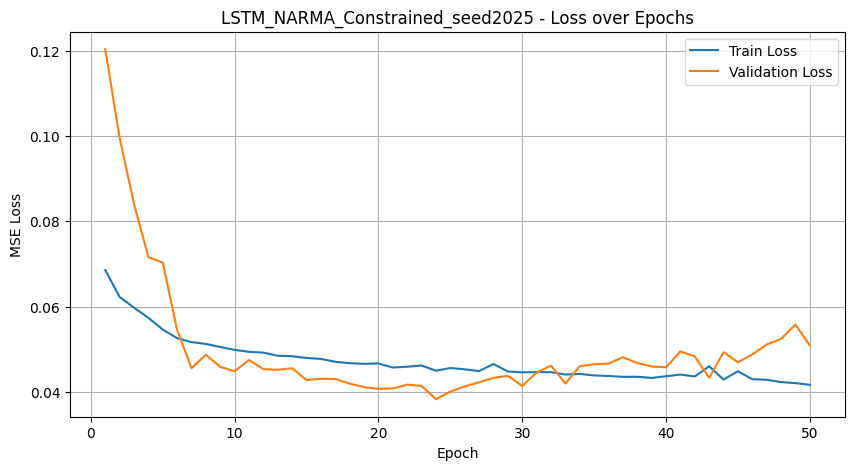


Generating final predictions on the full dataset...
Prediction plot saved to LSTM_NARMA_Constrained_seed2025/prediction_vs_truth.png


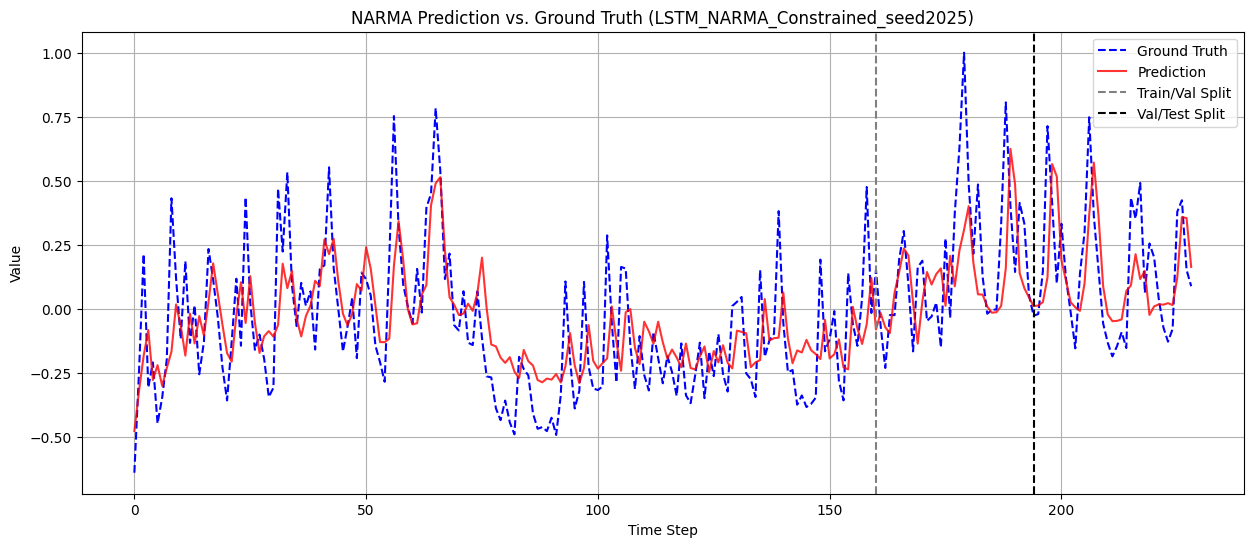

Predictions saved to LSTM_NARMA_Constrained_seed2025/prediction_vs_truth.csv

--- Running Final Experiment for Seed: 2026 ---
Getting NARMA data for seed 2026...
seed: 2026
Number of trainable parameters: 361
Epoch 10/50 - Train Loss: 0.066777, Val Loss: 0.057043
Epoch 20/50 - Train Loss: 0.062739, Val Loss: 0.060769
Epoch 30/50 - Train Loss: 0.059364, Val Loss: 0.063562
Epoch 40/50 - Train Loss: 0.054936, Val Loss: 0.054803
Epoch 50/50 - Train Loss: 0.055276, Val Loss: 0.068327

--- Final Training Complete for Seed {seed} ---
Final Test Loss for Seed 2026: 0.032271
Final metrics saved to LSTM_NARMA_Constrained_seed2026/final_training_metrics.csv
Plot saved to LSTM_NARMA_Constrained_seed2026/loss_plot.png


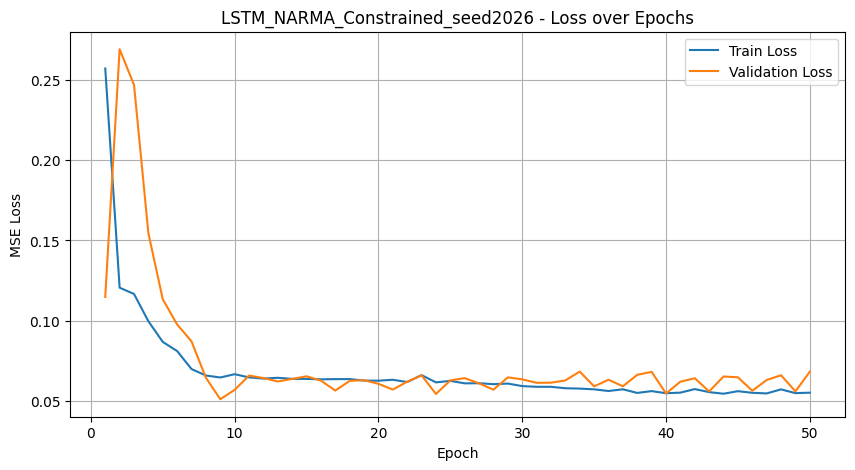


Generating final predictions on the full dataset...
Prediction plot saved to LSTM_NARMA_Constrained_seed2026/prediction_vs_truth.png


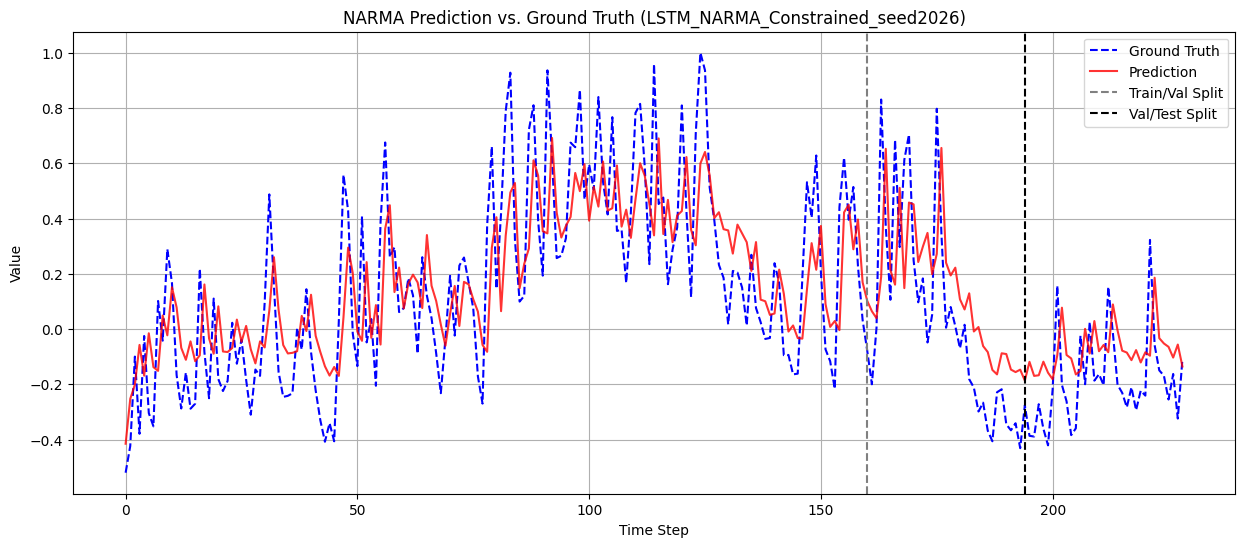

Predictions saved to LSTM_NARMA_Constrained_seed2026/prediction_vs_truth.csv

--- Running Final Experiment for Seed: 2027 ---
Getting NARMA data for seed 2027...
seed: 2027
Number of trainable parameters: 361
Epoch 10/50 - Train Loss: 0.077039, Val Loss: 0.091512
Epoch 20/50 - Train Loss: 0.070905, Val Loss: 0.101673
Epoch 30/50 - Train Loss: 0.068485, Val Loss: 0.089503
Epoch 40/50 - Train Loss: 0.069799, Val Loss: 0.106742
Epoch 50/50 - Train Loss: 0.067923, Val Loss: 0.084977

--- Final Training Complete for Seed {seed} ---
Final Test Loss for Seed 2027: 0.059902
Final metrics saved to LSTM_NARMA_Constrained_seed2027/final_training_metrics.csv
Plot saved to LSTM_NARMA_Constrained_seed2027/loss_plot.png


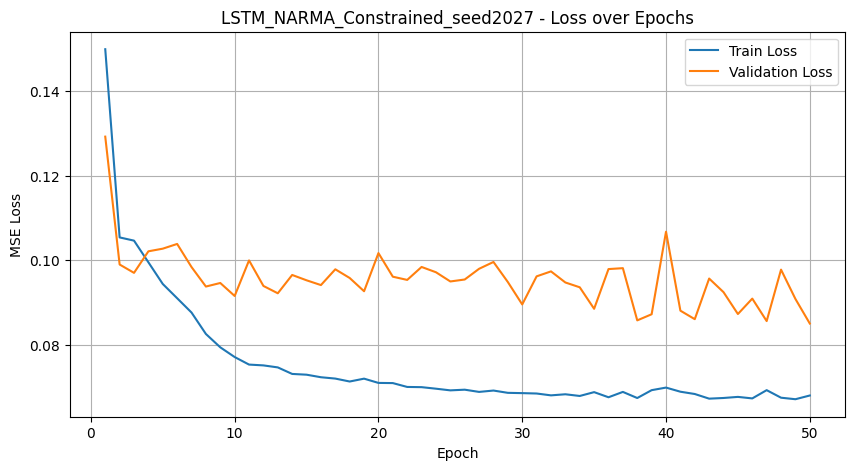


Generating final predictions on the full dataset...
Prediction plot saved to LSTM_NARMA_Constrained_seed2027/prediction_vs_truth.png


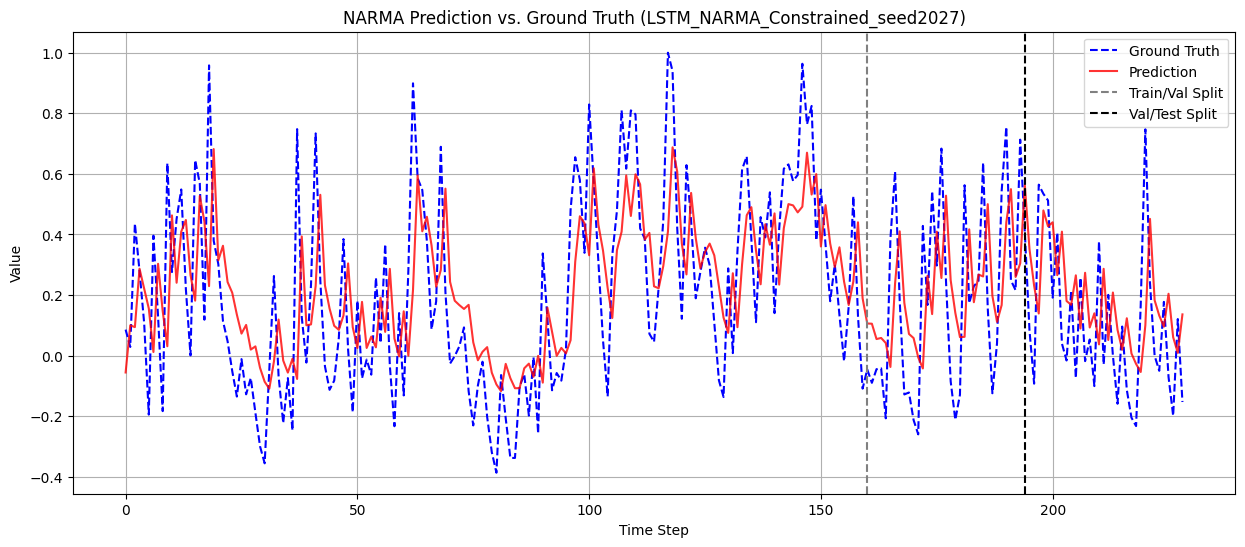

Predictions saved to LSTM_NARMA_Constrained_seed2027/prediction_vs_truth.csv


In [6]:
import torch
import torch.nn as nn
import numpy as np
import os
import time
from datetime import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
import itertools

# Make sure narma.py is in the same directory or accessible
from narma import get_narma_data

def count_parameters(model):
    """Counts the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ===================================================================
# 1. Configuration and Hyperparameter Grid
# ===================================================================
# --- Seed Configuration ---
TUNING_SEED = 2025
EVALUATION_SEEDS = [2025, 2026, 2027]

# --- Training Configuration ---
FINAL_EPOCHS = 50 # Epochs for the final model after finding best params
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================================================================
# 2. Model Definition
# ===================================================================
class LSTMModel(nn.Module):
    """A standard LSTM model for sequence prediction."""
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# ===================================================================
# 3. Helper Functions
# ===================================================================
def train_epoch(model, optimizer, loader, loss_fn, device):
    model.train()
    total_loss = 0
    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = loss_fn(output.squeeze(), Y_batch.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def test_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            output = model(X_batch)
            loss = loss_fn(output.squeeze(), Y_batch.squeeze())
            total_loss += loss.item()
    return total_loss / len(loader)

def save_and_plot_metrics(exp_name, metrics_data):
    if not os.path.exists(exp_name):
        os.makedirs(exp_name)
    df_metrics = DataFrame(metrics_data)
    csv_path = os.path.join(exp_name, "final_training_metrics.csv")
    df_metrics.to_csv(csv_path, index=False)
    print(f"Final metrics saved to {csv_path}")

    plt.figure(figsize=(10, 5))
    plt.plot(df_metrics['epoch'], df_metrics['train_loss'], label='Train Loss')
    plt.plot(df_metrics['epoch'], df_metrics['val_loss'], label='Validation Loss')
    plt.title(f'{exp_name} - Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plot_path = os.path.join(exp_name, "loss_plot.png")
    plt.savefig(plot_path)
    print(f"Plot saved to {plot_path}")
    plt.show()

def generate_and_save_predictions(model, full_data_x, full_data_y, train_end_idx, val_end_idx, exp_name):
    print("\nGenerating final predictions on the full dataset...")
    model.eval()
    with torch.no_grad():
        full_data_x = full_data_x.to(device)
        predictions = model(full_data_x).cpu().numpy().squeeze()
    
    ground_truth = full_data_y.cpu().numpy().squeeze()
    
    plt.figure(figsize=(15, 6))
    plt.plot(ground_truth, label='Ground Truth', color='blue', linestyle='--')
    plt.plot(predictions, label='Prediction', color='red', alpha=0.8)
    plt.axvline(x=train_end_idx, color='gray', linestyle='--', label='Train/Val Split')
    plt.axvline(x=val_end_idx, color='black', linestyle='--', label='Val/Test Split')
    plt.title(f'NARMA Prediction vs. Ground Truth ({exp_name})')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    
    plot_path = os.path.join(exp_name, "prediction_vs_truth.png")
    plt.savefig(plot_path)
    print(f"Prediction plot saved to {plot_path}")
    plt.show()
    
    df_preds = DataFrame({'ground_truth': ground_truth, 'prediction': predictions})
    csv_path = os.path.join(exp_name, "prediction_vs_truth.csv")
    df_preds.to_csv(csv_path, index=False)
    print(f"Predictions saved to {csv_path}")

# ===================================================================
# 4. Main Execution Block
# ===================================================================
# --- FINAL EVALUATION ON MULTIPLE SEEDS ---
print("\n" + "="*50)
print(f"STAGE 2: Starting Final Evaluation for Seeds: {EVALUATION_SEEDS}")
print("="*50)

for seed in EVALUATION_SEEDS:
    print(f"\n--- Running Final Experiment for Seed: {seed} ---")
    exp_name = f"LSTM_NARMA_Constrained_seed{seed}"
    
    # --- Setup for current seed ---
    torch.manual_seed(seed)
    np.random.seed(seed)

    # --- Data Loading for current seed ---
    print(f"Getting NARMA data for seed {seed}...")
    x, y = get_narma_data(n_samples=240, seq_length=10, seed=seed)
    if x.dim() == 2:
        x = x.unsqueeze(-1)
    
    train_end_idx = int(0.70 * len(x))
    val_end_idx = int(0.85 * len(x))
    x_train, y_train = x[:train_end_idx], y[:train_end_idx]
    x_val, y_val = x[train_end_idx:val_end_idx], y[train_end_idx:val_end_idx]
    x_test, y_test = x[val_end_idx:], y[val_end_idx:]

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val, y_val), batch_size=BATCH_SIZE)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=BATCH_SIZE)
    
    # --- Model Initialization with Best Hyperparameters ---
    final_model = LSTMModel(input_size=1, hidden_size=8, output_size=1, num_layers=1).to(device)
    print(f"Number of trainable parameters: {count_parameters(final_model):,}")
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(final_model.parameters(), lr=0.01)

    # --- Training Loop ---
    metrics = {'epoch': [], 'train_loss': [], 'val_loss': [], 'test_loss': []}
    for epoch in range(FINAL_EPOCHS):
        start_time = time.time()
        train_loss = train_epoch(final_model, optimizer, train_loader, loss_fn, device)
        val_loss = test_epoch(final_model, val_loader, loss_fn, device)
        test_loss = test_epoch(final_model, test_loader, loss_fn, device) if epoch == FINAL_EPOCHS - 1 else np.nan
        
        metrics['epoch'].append(epoch + 1)
        metrics['train_loss'].append(train_loss)
        metrics['val_loss'].append(val_loss)
        metrics['test_loss'].append(test_loss)
        
        if (epoch + 1) % 10 == 0: # Print progress every 10 epochs
            print(f"Epoch {epoch+1}/{FINAL_EPOCHS} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    print("\n--- Final Training Complete for Seed {seed} ---")
    final_test_loss = metrics['test_loss'][-1]
    print(f"Final Test Loss for Seed {seed}: {final_test_loss:.6f}")

    # --- Final Analysis ---
    save_and_plot_metrics(exp_name, metrics)
    generate_and_save_predictions(final_model, x, y, train_end_idx, val_end_idx, exp_name)

# Save grid search results for analysis in the first evaluation folder
first_eval_folder = f"LSTM_NARMA_Constrained_seed{EVALUATION_SEEDS[0]}"
